In [4]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [5]:
path = 'dataset_corrected/'
x1_train = pd.read_csv(path+'c_data_x1_train.csv')
x2_train = pd.read_csv(path+'c_data_x2_train.csv')
f1_train = pd.read_csv(path+'c_data_f1_train.csv')
f1_test = pd.read_csv(path+'c_data_f1_test.csv')
x1_test = pd.read_csv(path+'c_data_x1_test.csv')
x2_test = pd.read_csv(path+'c_data_x2_test.csv')

X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1))
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1))
X_train.head()

,0,1
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [6]:
from scipy import *
from scipy.linalg import norm, pinv
import math
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [7]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    # RBF MODEL
    rbf = RBF(2*m, 100, 1)
    t1 = datetime.now()
    rbf.train(x_train, y_train)
    t2 = datetime.now()
    
    print('\n\nTime taken by RBF Model: ',t2-t1)
    y1_pred = rbf.test(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    
    # GRADIENT BOOSTING
    gb = SVR()
    t1 = datetime.now()
    gb.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by SVR:',t2-t1)

    y1_pred = gb.predict(x_test)
    print('Root mean square error of SVR Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    y3 = y1_pred

    error9 = []
    for i in range(len(y_test)):
        error9.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error9))
    print('Maximum Error =',max(error9))
    error8 = sorted(error9)
    print('Median Value of Error =',error8[len(error9)//2])

    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y3[:6000], label = 'SVR')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()

    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error9[:6000], label = 'SVR')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # CatBoost model
    cat = CatBoostRegressor()
    t1 = datetime.now()
    cat.fit(x_train,y_train)
    t2 = datetime.now()
    print('\n\n\nTime taken by Cat Boosting:',t2-t1)

    y_pred = cat.predict(x_test)
    print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))
    
    error_cat = []
    for i in range(len(y_test)):
        error_cat.append(abs(y_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error_cat))
    print('Maximum Error =',max(error_cat))
    error8 = sorted(error_cat)
    print('Median Value of Error =',error8[len(error8)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y_pred[:6000], label = 'Cat Boost')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    # Error plots
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error9[:6000], label = 'SVR')
    plt.plot(list(range(6000)),error_cat[:6000], label = 'Cat Boosting Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

# Results

Time taken by Random Forest 0:01:43.020028
Root Mean Squared error of Random Forest 0.06222995553768425
Minimum Error = 1.000000000139778e-06
Maximum Error = 0.9001020000000015
Median Value of Error = 0.02090000000000003


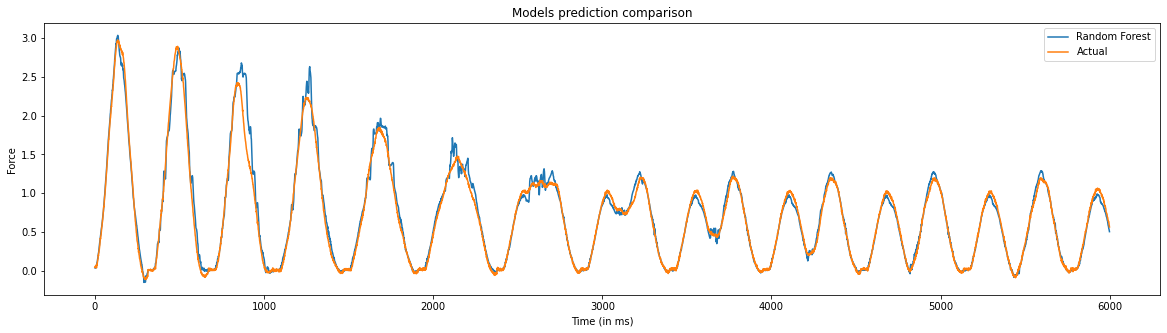



Time taken by RBF Model:  0:01:50.322113
Root mean square error of RBF Model:  0.050407014609548106
Minimum Error = [2.38181047e-07]
Maximum Error = [0.72527545]
Median Value of Error = [0.02269166]


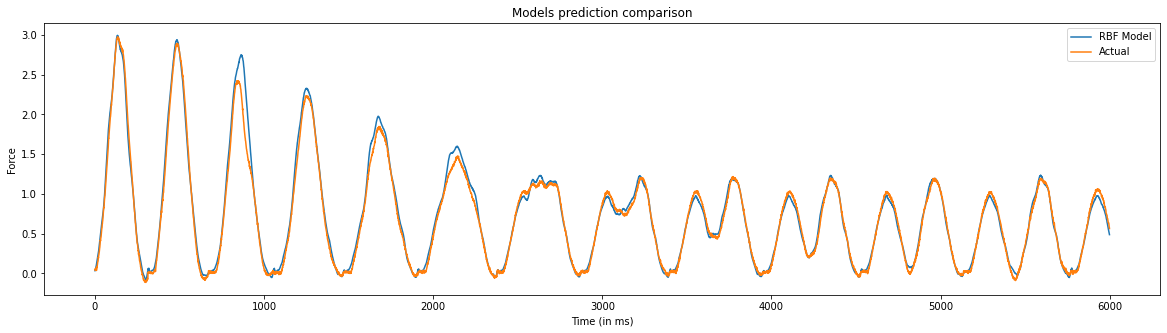

Time taken by SVR: 0:00:38.980670
Root mean square error of SVR Model:  0.050168891572613866
Minimum Error = 2.588452729934687e-09
Maximum Error = 0.6892579560464367
Median Value of Error = 0.02894990070993475


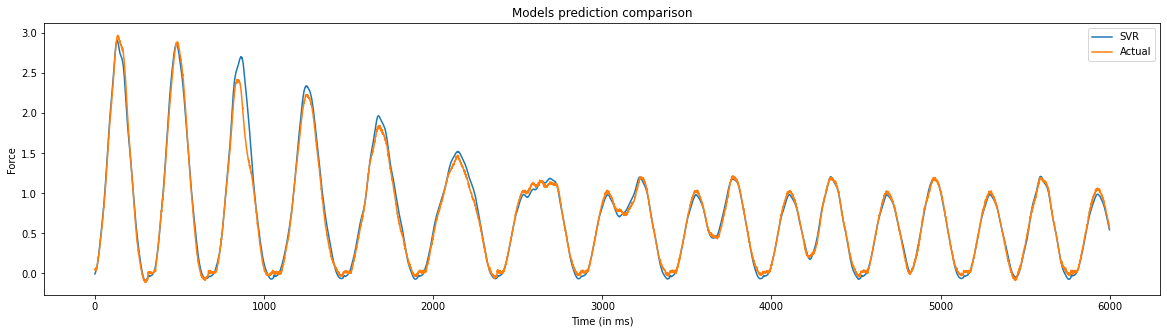

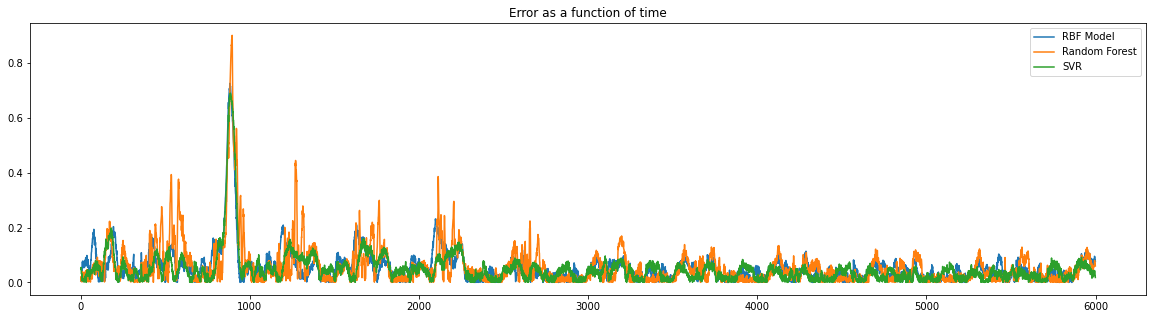

Learning rate set to 0.08682
0:	learn: 0.9230278	total: 58ms	remaining: 57.9s
1:	learn: 0.8475018	total: 66ms	remaining: 32.9s
2:	learn: 0.7784170	total: 71.8ms	remaining: 23.8s
3:	learn: 0.7149872	total: 77.2ms	remaining: 19.2s
4:	learn: 0.6572514	total: 82.6ms	remaining: 16.4s
5:	learn: 0.6051038	total: 88.2ms	remaining: 14.6s
6:	learn: 0.5565667	total: 93.1ms	remaining: 13.2s
7:	learn: 0.5121494	total: 98.7ms	remaining: 12.2s
8:	learn: 0.4716580	total: 104ms	remaining: 11.4s
9:	learn: 0.4346903	total: 108ms	remaining: 10.7s
10:	learn: 0.4014555	total: 113ms	remaining: 10.2s
11:	learn: 0.3708109	total: 119ms	remaining: 9.77s
12:	learn: 0.3430031	total: 125ms	remaining: 9.46s
13:	learn: 0.3174651	total: 130ms	remaining: 9.13s
14:	learn: 0.2946413	total: 135ms	remaining: 8.84s
15:	learn: 0.2734802	total: 140ms	remaining: 8.59s
16:	learn: 0.2540525	total: 145ms	remaining: 8.39s
17:	learn: 0.2370674	total: 153ms	remaining: 8.33s
18:	learn: 0.2215229	total: 160ms	remaining: 8.29s
19:	lear

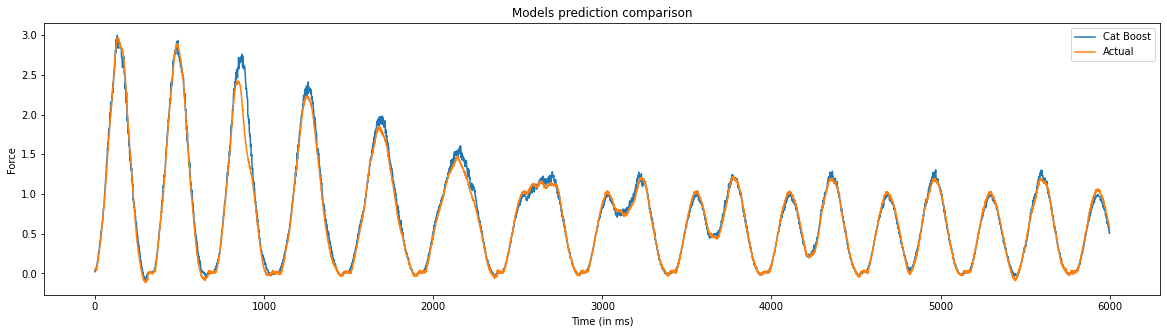

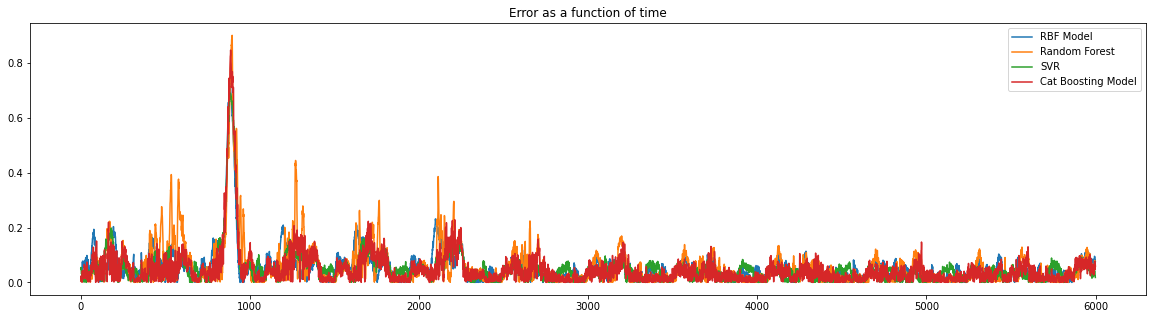

In [8]:
get_results(t=4,m=5)

Time taken by Random Forest 0:01:23.377331
Root Mean Squared error of Random Forest 0.06343707485052409
Minimum Error = 8.326672684688674e-17
Maximum Error = 0.9341700000000019
Median Value of Error = 0.020889000000000713


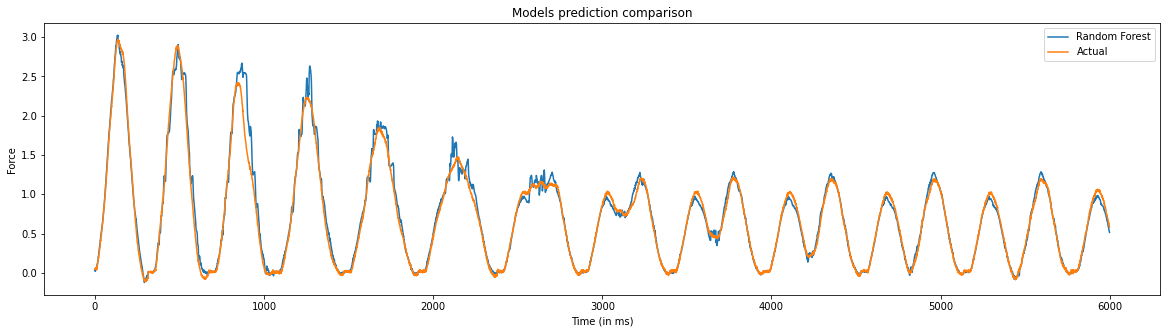



Time taken by RBF Model:  0:01:31.567789
Root mean square error of RBF Model:  0.04983057669270388
Minimum Error = [2.86291086e-07]
Maximum Error = [0.70327685]
Median Value of Error = [0.0206339]


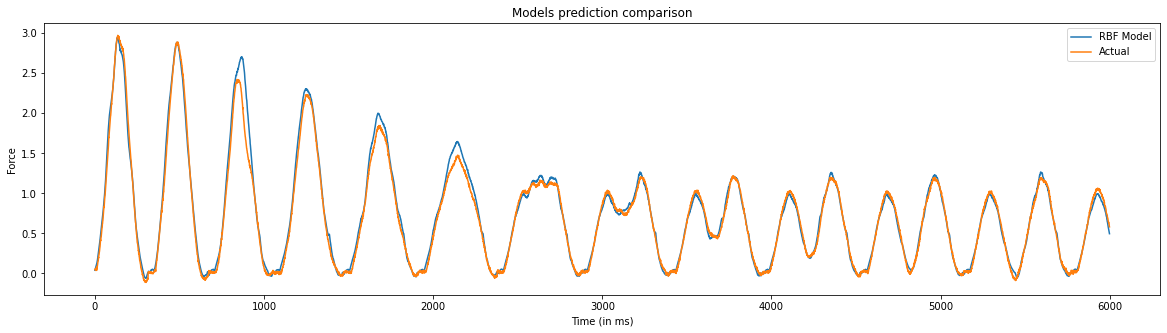

Time taken by SVR: 0:00:41.625604
Root mean square error of SVR Model:  0.05044754246187972
Minimum Error = 1.7475389085808146e-06
Maximum Error = 0.6841247596178734
Median Value of Error = 0.02949561706041917


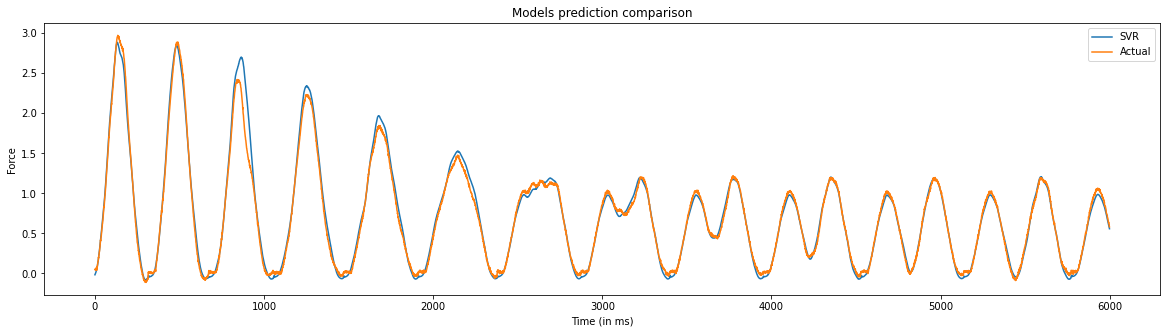

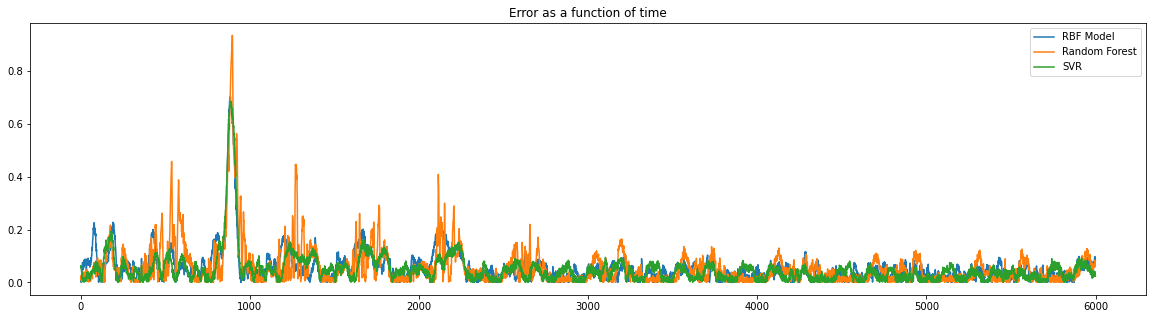

Learning rate set to 0.08682
0:	learn: 0.9237199	total: 9.13ms	remaining: 9.12s
1:	learn: 0.8479172	total: 15.3ms	remaining: 7.61s
2:	learn: 0.7784135	total: 20.1ms	remaining: 6.69s
3:	learn: 0.7151262	total: 25ms	remaining: 6.21s
4:	learn: 0.6568995	total: 29.5ms	remaining: 5.87s
5:	learn: 0.6039073	total: 34.3ms	remaining: 5.69s
6:	learn: 0.5556850	total: 39.2ms	remaining: 5.56s
7:	learn: 0.5114829	total: 44ms	remaining: 5.45s
8:	learn: 0.4713987	total: 59.3ms	remaining: 6.53s
9:	learn: 0.4344154	total: 65.1ms	remaining: 6.44s
10:	learn: 0.4007158	total: 70.6ms	remaining: 6.35s
11:	learn: 0.3698710	total: 75.4ms	remaining: 6.2s
12:	learn: 0.3422952	total: 80.3ms	remaining: 6.09s
13:	learn: 0.3164607	total: 85.4ms	remaining: 6.02s
14:	learn: 0.2932436	total: 90.6ms	remaining: 5.95s
15:	learn: 0.2723516	total: 96.1ms	remaining: 5.91s
16:	learn: 0.2529180	total: 104ms	remaining: 6.01s
17:	learn: 0.2354151	total: 109ms	remaining: 5.93s
18:	learn: 0.2195531	total: 114ms	remaining: 5.88s
1

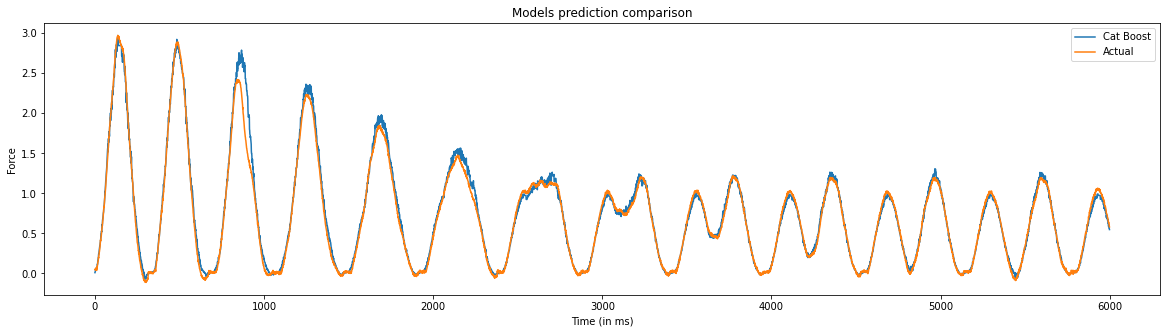

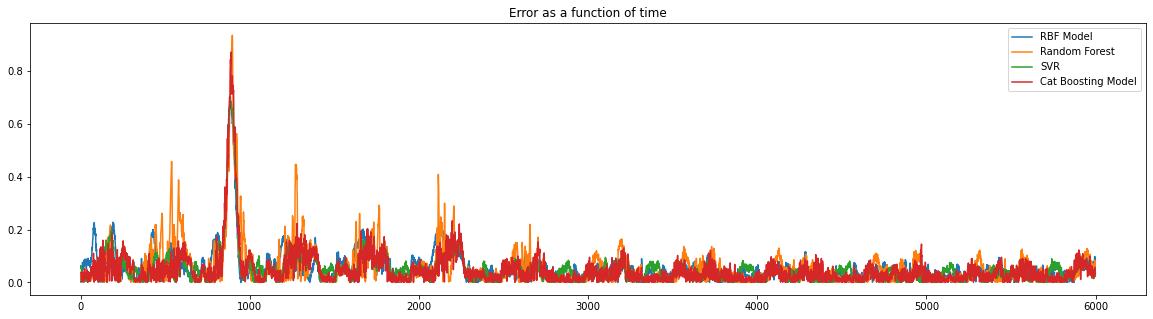

In [9]:
get_results(t=5,m=4)